In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader

In [2]:
seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
from google.oauth2 import service_account
from google.cloud import bigquery

SERVICE_ACCOUNT_FILE = "../../config/level3-416207-893f91c9529e.json"  # 키 json 파일

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

# 빅쿼리 클라이언트 객체 생성
project_id = "level3-416207"
client = bigquery.Client(credentials=credentials, project=project_id)


In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

# 쿼리 실행
# 빅쿼리 디렉토리는 <프로젝트ID>.<데이터셋ID>.<테이블ID> 순으로 저장되어있음 ex) level3-416207.l3_30.l3_30
QUERY = (
    '''
    SELECT 
        hashed_ip,
        user_device_endpoint,
        local_time,
        request_url_endpoint,
        keywords_list,
        uri_first
    FROM `level3-416207.log_129.user_device_log`
    ''')


# API request
df = client.query(QUERY).to_dataframe()

In [3]:
df = pd.read_csv('../../data/user_device_log.csv')
df.info()

/tmp/ipykernel_1927418/2192511439.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/user_device_log.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23622828 entries, 0 to 23622827
Data columns (total 7 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Unnamed: 0            int64 
 1   hashed_ip             object
 2   user_device_endpoint  object
 3   local_time            object
 4   request_url_endpoint  object
 5   keywords_list         object
 6   uri_first             object
dtypes: int64(1), object(6)
memory usage: 1.2+ GB


In [4]:
df = df[['user_device_endpoint', 'local_time', 'request_url_endpoint', 'keywords_list', 'uri_first']]

In [5]:
import pandas as pd

spec = df[df['request_url_endpoint'].str.startswith('/spec')]
comment = df[df['request_url_endpoint'].str.startswith('/comments')]
product = df[df['request_url_endpoint'].str.startswith('/products')]

df = pd.concat([product])
#df = pd.concat([spec, comment, product])

In [6]:
df['product_id'] = df['request_url_endpoint'].str.split('/').str[2]
df = df[df['product_id'].apply(lambda x: len(str(x)) == len('db696dbc255f0443bb7f782ac0ec24d45003f792cb9dbb7c810f7dd8216a18b2'))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1727615 entries, 2 to 9642464
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   user_device_endpoint  object
 1   local_time            object
 2   request_url_endpoint  object
 3   keywords_list         object
 4   uri_first             object
 5   product_id            object
dtypes: object(6)
memory usage: 92.3+ MB


In [7]:
df['user']=df['user_device_endpoint']
df['item']=df['product_id']

del df['request_url_endpoint'], df['local_time'], df['product_id'], df['uri_first'], df['keywords_list']

In [8]:
len(df['user'].unique())

4246

In [9]:
# import matplotlib.pyplot as plt

# # 사용자를 x축으로, 상호 작용 횟수를 y축으로 하는 그래프 그리기
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(selected_users)), selected_users.values, color='skyblue')
# # plt.xlabel('user')
# # plt.ylabel('interaction')
# plt.title('user interaction counts')
# # plt.xticks(rotation=45)  # x축 레이블 회전
# plt.tight_layout()  # 그래프 간격 조정
# plt.show()

In [10]:
# user별 interaction 개수를 계산
user_interaction_counts = df['user'].value_counts()

# interaction이 3개 이상인 user의 목록을 가져옴
selected_users = user_interaction_counts[user_interaction_counts >= 3].index

# interaction이 3개 이상인 user에 대한 데이터만 남김
df = df[df['user'].isin(selected_users)]
raw_rating_df = df

In [11]:
# 1. Rating df 생성

# raw_rating_df = pd.read_csv(rating_data)
# raw_rating_df
raw_rating_df['rating'] = 1.0 # implicit feedback
# raw_rating_df.drop(['time'],axis=1,inplace=True)
print("Raw rating df")
print(raw_rating_df)

users = set(raw_rating_df.loc[:, 'user'])
items = set(raw_rating_df.loc[:, 'item'])

Raw rating df
                     user_device_endpoint                              user  \
2        1ad94a1446fd930f13b89d54a558d42b  1ad94a1446fd930f13b89d54a558d42b   
5        372ebc160dc13e2061ccca7479625608  372ebc160dc13e2061ccca7479625608   
8        95b9b2997a29e6b3e1d25366907f5d21  95b9b2997a29e6b3e1d25366907f5d21   
17       d75c092099231db6df58c1a67446782b  d75c092099231db6df58c1a67446782b   
21       107898b861583db5a296b466c207b3c0  107898b861583db5a296b466c207b3c0   
...                                   ...                               ...   
9642421  344ccdb50fd11d0b5351cc97b6661b5d  344ccdb50fd11d0b5351cc97b6661b5d   
9642434  1b08cc472a23a66134f783c3ab6ba793  1b08cc472a23a66134f783c3ab6ba793   
9642437  1b08cc472a23a66134f783c3ab6ba793  1b08cc472a23a66134f783c3ab6ba793   
9642442  630ad21e25badeca5fe85d9b80d51921  630ad21e25badeca5fe85d9b80d51921   
9642464  be448bde05ee04dba69f3e8bed3e0fe9  be448bde05ee04dba69f3e8bed3e0fe9   

                                     

In [12]:
from tqdm import tqdm

#3. Negative instance 생성

# 시청횟수를 기준으로 raw_genre_df를 오름차순으로 정렬하고, 시청횟수가 적은 500개 아이템을 선택합니다.
# items_few_views = set(raw_genre_df.sort_values(by='views')['item'].head(500))

print("Create Nagetive instances")
num_negative = 50
user_group_dfs = list(df.groupby('user')['item'])
first_row = True
user_neg_dfs = pd.DataFrame()

for u, u_items in tqdm(user_group_dfs):
    u_items = set(u_items)
    i_user_neg_item = np.random.choice(list(items - u_items), num_negative, replace=False)
    
    i_user_neg_df = pd.DataFrame({'user': [u]*num_negative, 'item': i_user_neg_item, 'rating': [0]*num_negative})
    if first_row == True:
        user_neg_dfs = i_user_neg_df
        first_row = False
    else:
        user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

raw_rating_df = pd.concat([raw_rating_df, user_neg_dfs], axis = 0, sort=False)

# 4. Join inter_df, genre_df dfs
# joined_rating_df = pd.merge(raw_rating_df, raw_genre_df, left_on='item', right_on='item', how='inner')
# print("Joined rating df")
# print(joined_rating_df)

# 5. Embedding을 위해서 user,item,genre를 zero-based index로 mapping(Zero-based Indexing)
#     - Zero-based Indexing :  item 을 0부터 시작하는 인덱스 데이터에 대한 순서 정보로 처리 지만, 여기서는 단순 레이블 인코딩
#     - user : 0-31359 / 31360 명
#     - item : 0-6806  / 6807 영화 수 / 최대값 68319 있음
#     - genre : 0-17   / 18 장르 수
# users = list(set(joined_rating_df.loc[:,'user']))
# users.sort()
# items =  list(set((joined_rating_df.loc[:, 'item'])))
# items.sort()
# genres =  list(set((joined_rating_df.loc[:, 'genre'])))
# genres.sort()


users = list(set(raw_rating_df.loc[:,'user']))
users.sort()
items =  list(set((raw_rating_df.loc[:, 'item'])))
items.sort()
#
# user 인덱싱
if len(users)-1 != max(users):
    users_dict = {users[i]: i for i in range(len(users))}
    raw_rating_df['user']  = raw_rating_df['user'].map(lambda x : users_dict[x])
    users = list(set(raw_rating_df.loc[:,'user']))
# item 인덱싱    
if len(items)-1 != max(items):
    items_dict = {items[i]: i for i in range(len(items))}
    raw_rating_df['item']  = raw_rating_df['item'].map(lambda x : items_dict[x])
    items =  list(set((raw_rating_df.loc[:, 'item'])))

joined_rating_df = raw_rating_df.sort_values(by=['user'])
joined_rating_df.reset_index(drop=True, inplace=True)

data = joined_rating_df
print("Data")
print(data)

n_data = len(data)
n_user = len(users)
n_item = len(items)
# n_genre = len(genres)

print("# of data : {}\n# of users : {}\n# of items : {}\n".format(n_data, n_user, n_item))

Create Nagetive instances


100%|██████████| 4049/4049 [01:36<00:00, 42.06it/s]


Data
                     user_device_endpoint  user   item  rating
0                                     NaN     0   2540     0.0
1                                     NaN     0  27016     0.0
2                                     NaN     0  15600     0.0
3                                     NaN     0  30395     0.0
4        0000b3bd89ce5751f77754172ffdd28b     0  32893     1.0
...                                   ...   ...    ...     ...
1929779                               NaN  4048   5354     0.0
1929780                               NaN  4048  14146     0.0
1929781                               NaN  4048  25579     0.0
1929782                               NaN  4048  14303     0.0
1929783                               NaN  4048   8918     0.0

[1929784 rows x 4 columns]
# of data : 1929784
# of users : 4049
# of items : 33196



In [13]:
df = data[['user', 'item', 'rating']]
df

,user,item,rating
0,0,2540,0.0
1,0,27016,0.0
2,0,15600,0.0
3,0,30395,0.0
4,0,32893,1.0
...,...,...,...
1929779,4048,5354,0.0
1929780,4048,14146,0.0
1929781,4048,25579,0.0
1929782,4048,14303,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929784 entries, 0 to 1929783
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   user    int64  
 1   item    int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 44.2 MB


In [15]:
df['user'] = df['user'].astype("category")
df['item'] = df['item'].astype("category")

/tmp/ipykernel_1927418/2941368582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user'] = df['user'].astype("category")
/tmp/ipykernel_1927418/2941368582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item'] = df['item'].astype("category")


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# train_X, test_X, train_y, test_y = train_test_split(
#     df.loc[:, df.columns != 'rating'], df['rating'], test_size=0.2, random_state=seed)

# 전체 데이터를 train과 나머지로 나눔
train_X, rest_X, train_y, rest_y = train_test_split(
    df.loc[:, df.columns != 'rating'], df['rating'], test_size=0.2, random_state=seed)

# 나머지를 다시 valid과 test로 나눔
valid_X, test_X, valid_y, test_y = train_test_split(
    rest_X, rest_y, test_size=0.5, random_state=seed)

print('학습 데이터 크기:', train_X.shape, train_y.shape)
print('검증 데이터 크기:', valid_X.shape, valid_y.shape)
print('테스트 데이터 크기:', test_X.shape, test_y.shape)

학습 데이터 크기: (1543827, 2) (1543827,)
검증 데이터 크기: (192978, 2) (192978,)
테스트 데이터 크기: (192979, 2) (192979,)


In [17]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환
train_dataset = TensorDataset(torch.LongTensor(np.array(train_X)), torch.FloatTensor(np.array(train_y)))
valid_dataset = TensorDataset(torch.LongTensor(np.array(valid_X)), torch.FloatTensor(np.array(valid_y)))
test_dataset = TensorDataset(torch.LongTensor(np.array(test_X)), torch.FloatTensor(np.array(test_y)))

## Neural Collaborative Filtering 

In [18]:
def activation_layer(activation_name='relu'):
    """
    Construct activation layers

    Args:
        activation_name: str, name of activation function
        emb_dim: int, used for Dice activation
    Return:
        activation: activation layer
    """
    if activation_name is None:
        activation = None
    elif isinstance(activation_name, str):
        if activation_name.lower() == 'sigmoid':
            activation = nn.Sigmoid()
        elif activation_name.lower() == 'tanh':
            activation = nn.Tanh()
        elif activation_name.lower() == 'relu':
            activation = nn.ReLU()
        elif activation_name.lower() == 'leakyrelu':
            activation = nn.LeakyReLU()
        elif activation_name.lower() == 'none':
            activation = None
    elif issubclass(activation_name, nn.Module):
        activation = activation_name()
    else:
        raise NotImplementedError("activation function {} is not implemented".format(activation_name))

    return activation

In [19]:
class MLPLayers(nn.Module):
    """
    여러 층의 MLP Layer Class

    Args:
        - layers: (List) input layer, hidden layer, output layer의 node 수를 저장한 List.
                ex) [5, 4, 3, 2] -> input layer: 5 nodes, output layer: 2 nodes, hidden layers: 4 nodes, 3 nodes
        - dropout: (float) dropout 확률
        - activation: (str) activation function의 함수. Default: 'relu'
    Shape:
        - Input: (torch.Tensor) input features. Shape: (batch size, # of input nodes)
        - Output: (torch.Tensor) output features. Shape: (batch size, # of output nodes)
    """
    def __init__(self, layers, dropout, activation='relu'):
        super(MLPLayers, self).__init__()

        # initialize Class attributes
        self.layers = layers
        self.n_layers = len(self.layers) - 1
        self.dropout = dropout
        self.activation = activation

        # define layers
        mlp_modules = list()
        for i in range(self.n_layers):
            mlp_modules.append(nn.Dropout(p=self.dropout))
            input_size = self.layers[i]
            output_size = self.layers[i+1]
            mlp_modules.append(nn.Linear(input_size, output_size))
            activation_function = activation_layer(self.activation)
            if activation_function is not None:
                mlp_modules.append(activation_function)

        self.mlp_layers = nn.Sequential(*mlp_modules)

        self.apply(self._init_weights)

    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)

    def forward(self, input_feature):
        return self.mlp_layers(input_feature)

In [20]:
class NCF(nn.Module):
    """
    Neural Collaborative Filtering

    Args:
        - n_users: (int) 전체 유저의 수
        - n_items: (int) 전체 아이템의 수
        - emb_dim: (int) Embedding의 Dimension
        - layers: (List) Neural CF Layers의 각 node 수를 저장한 List.
                ex) [5, 4, 3, 2] -> hidden layers: 5 nodes, 4 nodes, 3 nodes, 2 nodes
        - dropout: (float) dropout 확률
    Shape:
        - Input: (torch.Tensor) input features, (user_id, item_id). Shape: (batch size, 2)
        - Output: (torch.Tensor) expected implicit feedback. Shape: (batch size,)
    """
    def __init__(self, n_users, n_items, emb_dim, layers, dropout):
        super(NCF, self).__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.layers = layers
        self.n_layers = len(self.layers) + 1
        self.dropout = dropout

        # define layers
        self.user_embedding = nn.Embedding(self.n_users, self.emb_dim)
        self.item_embedding = nn.Embedding(self.n_items, self.emb_dim)
        self.mlp_layers = MLPLayers([2 * self.emb_dim] + self.layers, self.dropout)
        self.predict_layer = nn.Linear(self.layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

        self.apply(self._init_weights)

    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)

    def forward(self, input_feature):
        user, item = torch.split(input_feature, [1, 1], -1)
        user = user.squeeze(-1)
        item = item.squeeze(-1)

        user_e = self.user_embedding(user)
        item_e = self.item_embedding(item)

        input_feature = torch.cat((user_e, item_e), -1)
        mlp_output = self.mlp_layers(input_feature)
        output = self.predict_layer(mlp_output)
        output = self.sigmoid(output)
        return output.squeeze(-1)

In [21]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (batch+1) % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches

    return train_loss


def test_loop(dataloader, model, loss_fn, err_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    test_err = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            if err_fn is not None:
                test_err += err_fn(pred, y).item()
    test_loss /= num_batches
    test_err /= num_batches
    if err_fn is not None:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}\n\tError: {(test_err):>8f}")
    else:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}")
    return test_loss, test_err

In [22]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, err_fn, optimizer, epochs):
    train_loss, test_loss, test_err = list(), list(), list()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_result= train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(train_result)
        test_result = test_loop(test_dataloader, model, loss_fn, err_fn)
        test_loss.append(test_result[0])
        test_err.append(test_result[1])
        print("-------------------------------\n")
    print("Done!")

    return train_loss, test_loss, test_err

In [23]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, y):
        loss = nn.MSELoss()(pred, y)
        return torch.sqrt(loss)

In [24]:
######## Hyperparameter ########

batch_size = 2048
data_shuffle = True
emb_dim = 512
layers = [256, 64]
dropout = 0
epochs = 10
learning_rate = 0.001
gpu_idx = 0
weight_decay = 1e-4
n_users = df['user'].nunique()
n_items = df['item'].nunique()

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=data_shuffle)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=data_shuffle)

model = NCF(n_users, n_items, emb_dim, layers, dropout).to(device)

loss_fn = nn.BCELoss().to(device)
err_fn = None
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True, weight_decay=weight_decay)

In [25]:
train_loss, val_loss, val_err = train_and_test(train_dataloader, valid_dataloader, model, loss_fn, err_fn, optimizer, epochs)

Epoch 1
-------------------------------
Loss: 0.146619 | [202752/1543827]
Loss: 0.149453 | [407552/1543827]
Loss: 0.165545 | [612352/1543827]
Loss: 0.134541 | [817152/1543827]
Loss: 0.128882 | [1021952/1543827]
Loss: 0.145231 | [1226752/1543827]
Loss: 0.123578 | [1431552/1543827]
Test Error:
	Avg Loss: 0.125526
-------------------------------

Epoch 2
-------------------------------
Loss: 0.109788 | [202752/1543827]
Loss: 0.118021 | [407552/1543827]
Loss: 0.115581 | [612352/1543827]
Loss: 0.101264 | [817152/1543827]
Loss: 0.118724 | [1021952/1543827]
Loss: 0.112987 | [1226752/1543827]
Loss: 0.114561 | [1431552/1543827]
Test Error:
	Avg Loss: 0.115972
-------------------------------

Epoch 3
-------------------------------
Loss: 0.096149 | [202752/1543827]
Loss: 0.092063 | [407552/1543827]
Loss: 0.116629 | [612352/1543827]
Loss: 0.125057 | [817152/1543827]
Loss: 0.112804 | [1021952/1543827]
Loss: 0.110114 | [1226752/1543827]
Loss: 0.120919 | [1431552/1543827]
Test Error:
	Avg Loss: 0.11

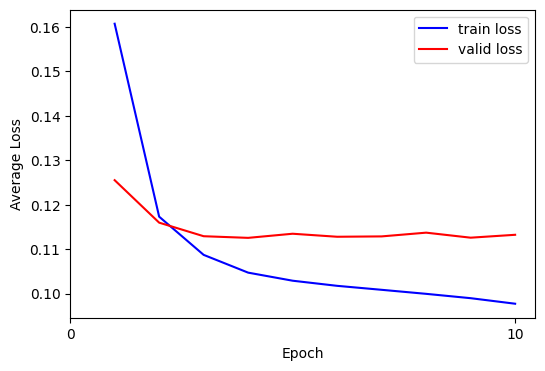

In [44]:
fig, (loss_ax) = plt.subplots(1,1, figsize=(6,4))


loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='train loss')
loss_ax.plot(range(1,epochs+1), val_loss, 'r', label='valid loss')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

plt.show()

In [28]:
def inference(model, dataloader, threshold=0.5):
    """
    모델을 사용하여 테스트 데이터에 대한 추론을 수행합니다.

    Args:
        model: PyTorch 모델 인스턴스
        dataloader: 테스트 데이터를 제공하는 DataLoader 인스턴스

    Returns:
        predictions: 모델의 이진 예측 결과를 담은 리스트
        targets: 실제 타겟 값(레이블)을 담은 리스트
    """
    model.eval()  # 모델을 evaluation 모드로 설정

    preds = []
    probs = []
    targets = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logit = model(X)  # 모델로 예측 수행 (확률값이 아닌 logits)
            pred = (logit >= threshold).int()  # 확률값을 이진값으로 변환
            probs.extend(logit)
            preds.extend(pred.cpu().tolist())  # 이진값을 리스트에 추가
            targets.extend(y.cpu().tolist())  # 실제 타겟 값을 리스트에 추가

    return probs, preds, targets


In [29]:
def accuracy(preds, targets):
    """
    예측값과 타겟값을 비교하여 정확도를 계산합니다.

    Args:
        predictions: 모델의 예측 결과를 담은 리스트 (이진값)
        targets: 실제 타겟 값(레이블)을 담은 리스트

    Returns:
        accuracy: 정확도
    """
    correct = sum(pred == target for pred, target in zip(preds, targets))
    total = len(targets)
    accuracy = correct / total
    return accuracy


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
import numpy as np

def calculate_rmse(preds, targets):
    # 예측값과 실제값의 RMSE 계산
    rmse = np.sqrt(mean_squared_error(targets, preds))
    return rmse


In [31]:
probs, preds, targets = inference(model=model, dataloader=valid_dataloader)

In [32]:
print("RMSE:", calculate_rmse(probs, targets))
print("ACC: ", accuracy(preds, targets))
print("F1 score:", f1_score(y_true=targets, y_pred=preds))
print("ROC AUC score:", roc_auc_score(y_true=targets, y_score=probs))

RMSE: 0.18092908240713393
ACC:  0.9561452600814601
F1 score: 0.9756372795969773


In [34]:
probs, preds, targets = inference(model=model, dataloader=test_dataloader)

In [36]:
print("ACC: ", accuracy(preds, targets))
print("RMSE:", calculate_rmse(probs, targets))
print("F1 score:", f1_score(y_true=targets, y_pred=preds))
print("ROC AUC score:", roc_auc_score(y_true=targets, y_score=probs))

ACC:  0.9569538654464994
RMSE: 0.17932947718766334
F1 score: 0.9760831948959056
ROC AUC score: 0.9761981737188283


In [38]:
test_y

819606     1.0
1517506    1.0
734491     1.0
720838     1.0
1559624    1.0
          ... 
1538037    1.0
1179194    1.0
1859039    0.0
1684517    1.0
1122054    1.0
Name: rating, Length: 192979, dtype: float64

In [39]:
# test_y 배열에서 1과 0의 개수를 세기
counts = np.bincount(test_y)
num_ones = counts[1]
num_zeros = counts[0]

# 1과 0의 개수를 출력
print("Number of ones (positive class):", num_ones)
print("Number of zeros (negative class):", num_zeros)

# 1과 0의 비율을 계산하여 출력
ratio_ones = num_ones / len(test_y)
ratio_zeros = num_zeros / len(test_y)
print("Ratio of ones (positive class):", ratio_ones)
print("Ratio of zeros (negative class):", ratio_zeros)

Number of ones (positive class): 172709
Number of zeros (negative class): 20270
Ratio of ones (positive class): 0.8949626643313521
Ratio of zeros (negative class): 0.10503733566864788


In [41]:
# 모델 저장 경로
model_path = 'ncf.pt'
# 모델의 상태를 딕셔너리 형태로 가져오기
model_state = model.state_dict()
# 모델 상태를 파일로 저장
torch.save(model_state, model_path)

## 모델 서빙할때 사용할 코드

In [73]:
from collections import defaultdict

# 모든 사용자-아이템 쌍에 대한 결과 생성 후 랭킹
u_list = []
i_list = []
ritems_dict = {v: k for k, v in items_dict.items()}
hit_count = 0
total_count = 0
hit_rate_dict = defaultdict(int)

for u, u_items in tqdm(user_group_dfs):

    # 인코딩하기 전에 유저id 저장
    u_list.append([u] * 10)

    # user encoding
    u = users_dict[u]
    u_items = set(u_items.map(lambda x: items_dict[x]))  # encoding된 유저의 시청 아이템

    # user, item, genre 데이터를 인코딩하여 학습한 모델에 맞는 값으로 변환
    i_user_col = torch.tensor([u] * n_item)
    i_item_col = torch.tensor(list(raw_rating_df['item'].unique()))

    x = torch.cat([i_user_col.unsqueeze(1), i_item_col.unsqueeze(1)], dim=1)
    x = x.to(device)

    model.eval()
    output_batch = model(x)
    output_batch = output_batch.cpu().detach().numpy()

    output_batch[list(u_items)] = -1  # 이미 본 아이템 제외
    result_batch = np.argsort(output_batch)[-10:][::-1]  # Top 10 item_id 추출
    i_list.append(list(map(lambda x: ritems_dict[x], result_batch)))  # item decoding

#     # Hit rate 계산
#     for recommended_item in result_batch:
#         if recommended_item in u_items:
#             hit_count += 1
#             hit_rate_dict[u] += 1
#         total_count += 1

# hit_rate = hit_count / total_count
# print("Hit rate:", hit_rate)

# # 각 사용자별 Hit rate 출력
# for user, hit_count_user in hit_rate_dict.items():
#     total_count_user = len(user_group_dfs[user])
#     hit_rate_user = hit_count_user / total_count_user
#     print(f"User {user}: Hit rate {hit_rate_user}")


  0%|          | 0/4049 [00:00<?, ?it/s]

100%|██████████| 4049/4049 [10:14<00:00,  6.59it/s]

Hit rate: 0.0
